# Fbeta Green

## 1. Import Packages

In [101]:
import os
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

import tensorflow as tf
import tensorflow_hub as hub  # noqa: F401
import tensorflow_text as text  # noqa: F401
from official.nlp import optimization
from asgard.utils.data_loader import load_datasets

from asgard.metrics.metrics import (
    compute_binary_metrics,
    print_multilabel_metrics,
)

from asgard.metrics.metrics import HammingScoreMetric
from asgard.utils.weights import get_weighted_loss

In [2]:
path = os.path.join(pathlib.Path().absolute(), '../')
os.chdir(path)

In [3]:
# custom matplotlib fonts
# https://python-graph-gallery.com/custom-fonts-in-matplotlib/

## 2. Utils

In [5]:
def normalize_to_range(x, min_val, max_val):
    # normalize metrics to a specified range: [min_val, max_val]
    if min_val >= max_val:
        raise ValueError("min_val must be less than max_val")
    
    # Calculate the normalized value using a linear transformation
    normalized_value = min_val + (max_val - min_val) * (x - x.min()) / (x.max() - x.min())
    
    return normalized_value


def normalization(metric, min, max):
    # normalize metrics [0, 1]
    return (metric - min) / (max - min)


def fbeta(metric1, metric2, beta=1):
    return (1 + beta**2) * metric1 * metric2 / ((beta**2) * metric1 + metric2)


def normalize(metric, n_reference=1):
    return metric / (n_reference * 20.525) 


def invert(metric):
    # apply linear transformation to revert metrics
    return 1 - metric



In [142]:
# references: 
# https://ranocha.de/blog/colors/#gsc.tab=0
# https://medium.com/p/d023f74515b4
# https://towardsdatascience.com/5-powerful-tricks-to-visualize-your-data-with-matplotlib-16bc33747e05
import os
from matplotlib.ticker import MultipleLocator
from cycler import cycler

style = 'default'

plt.style.use(style)

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0

plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0

plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['axes.linewidth'] = 3.0

plt.rcParams['legend.handlelength'] = 5.0

plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)
plt.rc("legend", loc="best", fontsize=10, fancybox=True, framealpha=0.5)
plt.rc("savefig", dpi=600)

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
plt.rc("axes", prop_cycle=line_cycler)

directory = "./notebooks/figs/"

## 3. Load Datasets

In [4]:
train_set, valid_set, test_set = load_datasets("./storage/datasets/tf_raw")

2023-08-13 15:33:56.393740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-13 15:33:56.843028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-13 15:33:56.844693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-13 15:33:56.848297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

## 3. Experiment Results

In [7]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("alexandre-hsd/ASGARD")

summary_list, config_list, name_list, id_list = [], [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
        if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    id_list.append(run.id)

In [8]:
# keep all runs in a single DataFrame
runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "id": id_list
    })

In [9]:
results = pd.DataFrame(data=summary_list)
results["name"] = name_list
results["run_id"] = id_list

### 3.1 Exploratory Data Analysis 

In [64]:
results.groupby("Model Architecture")['_runtime'].mean() / 3600

Model Architecture
BERT          23.451366
DistilBERT    13.593916
RNN            3.848833
Name: _runtime, dtype: float64

In [53]:
# average Co2 emissions (Kg) by architecture
results.groupby("Model Architecture")['Co2 Emissions'].mean()

Model Architecture
bert          2.712043
distilbert    1.567399
rnn           0.347876
Name: Co2 Emissions, dtype: float64

In [54]:
# average Co2 emissions rate (Kg/s) by architecture
results.groupby("Model Architecture")['Co2 Emissions Rate'].mean()

Model Architecture
bert          0.000033
distilbert    0.000033
rnn           0.000026
Name: Co2 Emissions Rate, dtype: float64

In [54]:
results.loc[results["Model Architecture"] == "bert", "Model Architecture"] = "BERT"
results.loc[results["Model Architecture"] == "distilbert", "Model Architecture"] = "DistilBERT"
results.loc[results["Model Architecture"] == "rnn", "Model Architecture"] = "RNN"

In [66]:
results.columns.tolist()

['loss',
 'Overall Recall',
 'Overall Precision',
 'graph',
 'Accuracy',
 'Model Architecture',
 'val_hamming_score',
 'Co2 Emissions Rate',
 'Number of Parameters',
 'Energy RAM',
 'Hamming Score',
 'Energy Consumed',
 'val_loss',
 'Hamming Loss',
 '_runtime',
 'Energy CPU',
 'Overall F1',
 '_timestamp',
 'Exact Match Ratio',
 'best_val_hamming_score',
 'Loss',
 '_step',
 'Energy GPU',
 'Validation Loss',
 'epoch',
 '_wandb',
 'best_epoch',
 'Co2 Emissions',
 'hamming_score',
 'Validation Accuracy',
 'name',
 'run_id']

In [67]:
results.groupby("Model Architecture")['Energy Consumed'].mean()

Model Architecture
BERT          4.078577
DistilBERT    2.357174
RNN           0.523162
Name: Energy Consumed, dtype: float64

In [68]:
results.groupby("Model Architecture")['Energy GPU'].mean()

Model Architecture
BERT          1.569022
DistilBERT    0.899847
RNN           0.105386
Name: Energy GPU, dtype: float64

In [69]:
results.groupby("Model Architecture")['Energy CPU'].mean()

Model Architecture
BERT          2.379449
DistilBERT    1.381774
RNN           0.396111
Name: Energy CPU, dtype: float64

In [70]:
results.groupby("Model Architecture")['Energy RAM'].mean()

Model Architecture
BERT          0.130106
DistilBERT    0.075554
RNN           0.021665
Name: Energy RAM, dtype: float64

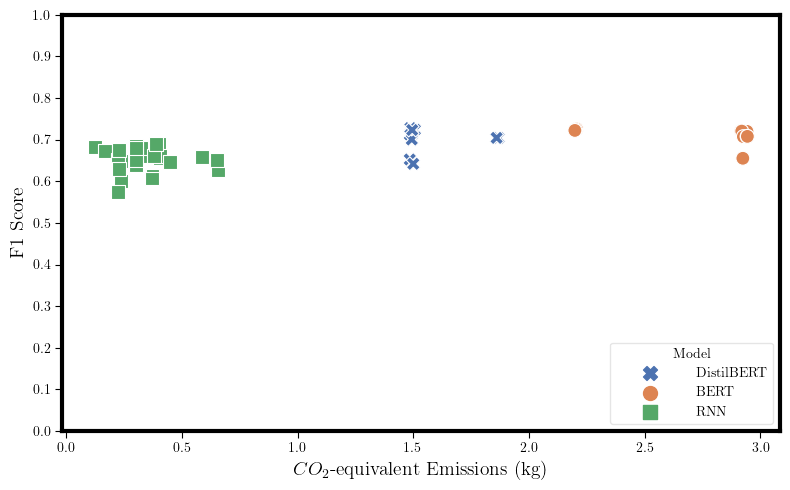

In [57]:
metric = "Overall F1"
figname = "f1_score.png"

fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
markers = {"BERT": "o", "DistilBERT": "X", "RNN": "s"}

sns.scatterplot(data=results, 
                x="Co2 Emissions", 
                y=metric, 
                hue="Model Architecture", 
                style="Model Architecture",
                palette="deep",
                markers=markers,
                ax=ax)

ax.set_yticks(np.arange(0.4, 1.0, 0.1))
ax.set_ylabel(metric)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# ax.set_title(f"{metric} x Co2 Emissions")
ax.set_xlabel("$CO_2$-equivalent Emissions (kg)")
ax.set_ylabel("F1 Score")

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.legend(title="Model", loc="lower right", markerscale=1)

plt.tight_layout()
plt.savefig(os.path.join(directory, figname), bbox_inches="tight")
plt.show()

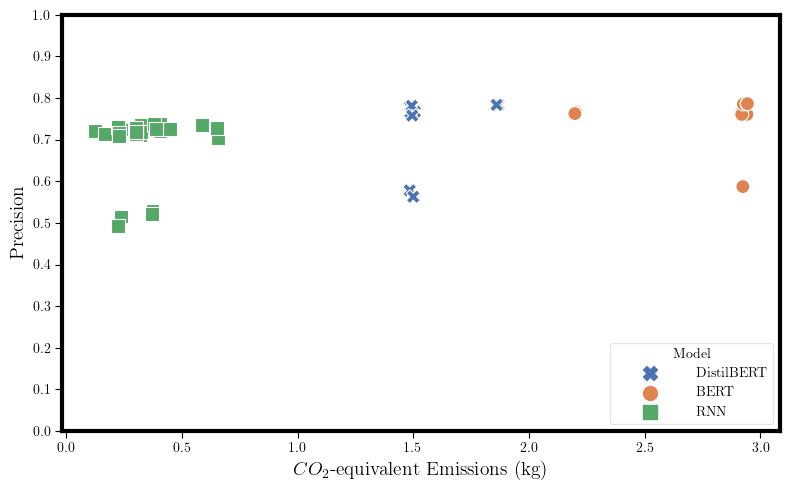

In [58]:
metric = "Overall Precision"
figname = "precision.png"

fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
markers = {"BERT": "o", "DistilBERT": "X", "RNN": "s"}

sns.scatterplot(data=results, 
                x="Co2 Emissions", 
                y=metric, 
                hue="Model Architecture", 
                style="Model Architecture",
                palette="deep",
                markers=markers,
                ax=ax)

ax.set_yticks(np.arange(0.4, 1.0, 0.1))
ax.set_ylabel(metric)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# ax.set_title(f"{metric} x Co2 Emissions")
ax.set_xlabel("$CO_2$-equivalent Emissions (kg)")
ax.set_ylabel("Precision")

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.legend(title="Model", loc="lower right", markerscale=1)

plt.tight_layout()
plt.savefig(os.path.join(directory, figname), bbox_inches="tight")
plt.show()

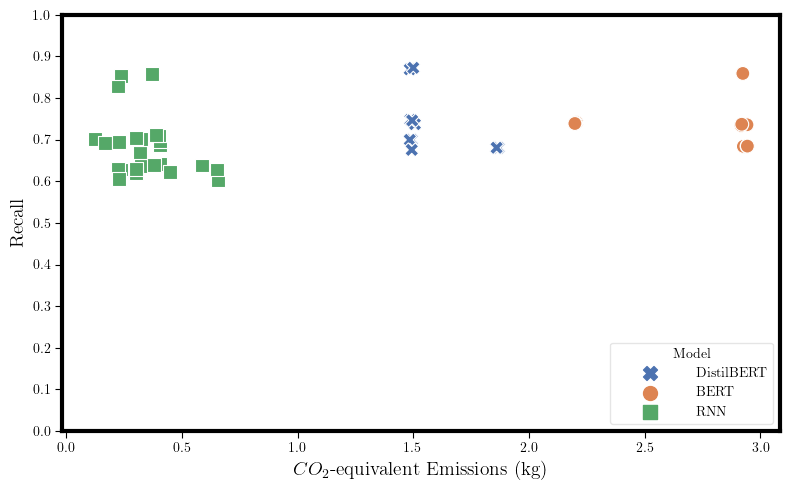

In [62]:
metric = "Overall Recall"
figname = "recall.png"

fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
markers = {"BERT": "o", "DistilBERT": "X", "RNN": "s"}

sns.scatterplot(data=results, 
                x="Co2 Emissions", 
                y=metric, 
                hue="Model Architecture", 
                style="Model Architecture",
                palette="deep",
                markers=markers,
                
                ax=ax)

ax.set_yticks(np.arange(0.4, 1.0, 0.1))
ax.set_ylabel(metric)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# ax.set_title(f"{metric} x Co2 Emissions")
ax.set_xlabel("$CO_2$-equivalent Emissions (kg)")
ax.set_ylabel("Recall")

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.legend(title="Model", loc="lower right", markerscale=1)

plt.tight_layout()
plt.savefig(os.path.join(directory, figname), bbox_inches="tight")
plt.show()

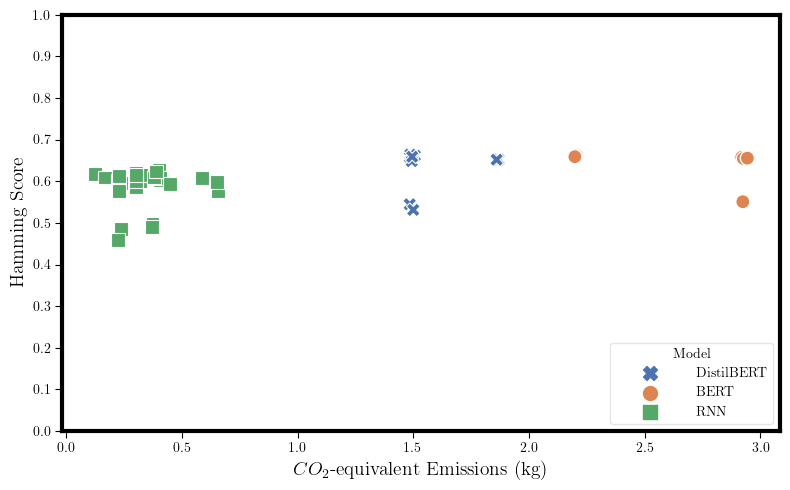

In [63]:
metric = "Hamming Score"
figname = "hamming_score.png"

fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
markers = {"BERT": "o", "DistilBERT": "X", "RNN": "s"}

sns.scatterplot(data=results, 
                x="Co2 Emissions", 
                y=metric, 
                hue="Model Architecture", 
                style="Model Architecture",
                palette="deep",
                markers=markers,
                ax=ax)

ax.set_yticks(np.arange(0.4, 1.0, 0.1))
ax.set_ylabel(metric)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# ax.set_title(f"{metric} x Co2 Emissions")
ax.set_xlabel("$CO_2$-equivalent Emissions (kg)")
ax.set_ylabel("Hamming Score")

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.legend(title="Model", loc="lower right", markerscale=1)

plt.tight_layout()
plt.savefig(os.path.join(directory, figname), bbox_inches="tight")
plt.show()

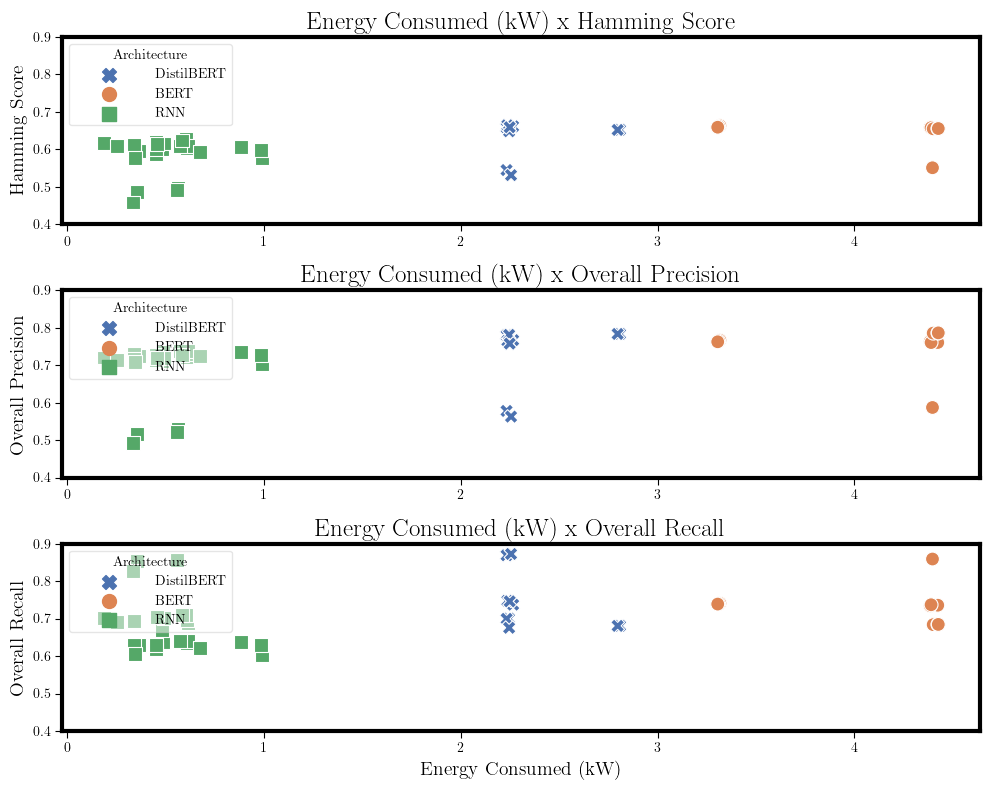

In [61]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
markers = {"BERT": "o", "DistilBERT": "X", "RNN": "s"}

for i, metric in enumerate(["Hamming Score", "Overall Precision", "Overall Recall"]):
    sns.scatterplot(data=results, 
                    x="Energy Consumed", 
                    y=metric, 
                    hue="Model Architecture", 
                    style="Model Architecture",
                    palette="deep",
                    markers=markers,
                    ax=ax[i])
    
    ax[i].set_yticks(np.arange(0.4, 1.0, 0.1))
    ax[i].set_ylabel(metric)
    
    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].set_title(f"Energy Consumed (kW) x {metric}")
    ax[i].set_xlabel("Energy Consumed (kW)")
    
    ax[i].legend(title="Architecture", loc="upper left")

plt.tight_layout()
plt.show()

### 3.2 F-Green

The F-Green Metric is a business metric that considers not only a given performance metric but also the model carbon footprint, when selecting models from a pool. 

In this work, are going to consider a F-beta Green that associates model Accuracy with the Co2 Emission (Kg) of the model. To do that, we need to normalize the Emission variable so that it won't completely dominates the accuracy metrics. That's why the accuracy metric ranges from $[0, 1]$, while the Emission variables ranges from $[0, +\infty]$.
To normalize the metric, we need to account for different references because some models emit less Co2 than others in order of magnitudes. So, to account for different orders of magnitude, our references will be units of trees:

One tree offsets around 21 Kg of Co2 each year. Thus, we propose the following references:

- 11 (1 Tree / six months)
- 22 Kg (1 Tree)
- 220 Kg (10 Trees)
- 2,200 Kg (100 Trees)

In [80]:
columns = ["name", "run_id", "Exact Match Ratio", "Hamming Score", "Overall Recall", "Overall Precision", "Overall F1", "Co2 Emissions", "Model Architecture"]
metrics = results[columns].copy()

In [81]:
trees = pd.read_csv("./notebooks/trees_carbon_sequester.csv")

In [82]:
survival = trees["Survival Factors Moderate"]
sequestration_conifer = trees["Growth Rate Moderate Conifer"]
sequestration_hardwood = trees["Growth Rate Moderate Hardwood"]

trees["Accumulated Carbon Sequester (lbs)"] = (
    0.11 * np.cumsum(survival * sequestration_conifer) + 
    0.89 * np.cumsum(survival * sequestration_hardwood)
) 

trees["Accumulated Carbon Sequester co2/tree"] = trees["Accumulated Carbon Sequester (lbs)"] * (44/12) * 1/2.20462

### 3.2.1 Fbeta Green With Normalized Emissions

In [83]:
metric = "Overall F1"

In [84]:
metrics["Co2 Emissions Normalized"] = normalize(metrics["Co2 Emissions"], n_reference=1)
metrics["Co2 Normalized Score"] = invert(metrics["Co2 Emissions Normalized"])

In [85]:
# beta 1: balance weight
metrics["F-Green"] = fbeta(metrics[metric], 
                           metrics["Co2 Normalized Score"], 
                           beta=1)

metrics["F05beta Normalized"] = fbeta(metrics[metric], 
                                      metrics["Co2 Normalized Score"], 
                                      beta=0.5)

metrics["F2beta Normalized"] = fbeta(metrics[metric], 
                                     metrics["Co2 Normalized Score"], 
                                     beta=2)

Okay, the best architectures according to the F-Green Metrics are:

In [86]:
architectures = ["RNN", "DistilBERT", "BERT"]
best_models = pd.DataFrame(columns=metrics.columns, index=list(range(len(architectures))))

for i, arch in enumerate(architectures):
    metrics_arch = metrics.loc[metrics["Model Architecture"] == arch, :]
    best_models.iloc[i, :] = metrics_arch.iloc[metrics_arch["F-Green"].argmax(), :]

In [87]:
best_models.sort_values(by="F-Green", ascending=False)

,name,run_id,Exact Match Ratio,Hamming Score,Overall Recall,Overall Precision,Overall F1,Co2 Emissions,Model Architecture,Co2 Emissions Normalized,Co2 Normalized Score,F-Green,F05beta Normalized,F2beta Normalized
1,confused-sweep-6,cp4c2cbu,0.474481,0.664182,0.747708,0.765217,0.727759,1.487458,DistilBERT,0.072471,0.927529,0.81559,0.760519,0.879258
0,honest-sweep-17,9mb0cypv,0.437405,0.626465,0.709941,0.729727,0.690641,0.401973,RNN,0.019585,0.980415,0.810404,0.734031,0.904514
2,valiant-sweep-6,nzm7z60p,0.476199,0.66293,0.740901,0.766824,0.725541,2.205768,BERT,0.107467,0.892533,0.80042,0.753746,0.853255


The models above were the ones that performed better against their counterparts w.r.t. the F-Green Metric. Overall, the distilbert (astral-sweep-10) model, was the champion. That is, it got the best F-Green performance amongst all others.

In [94]:
top_models = {"rnn": None, "distilbert": None, "bert": None}
top_models_green = {"rnn": None, "distilbert": None, "bert": None}

for i, arch in enumerate(architectures):
    top_models[arch] = (
        metrics
        .loc[metrics["Model Architecture"] == arch, :]
        .sort_values(by=metric, ascending=False)
        .head(5)
    )
    
    top_models_green[arch] = (
        metrics
        .loc[metrics["Model Architecture"] == arch, :]
        .sort_values(by="F-Green", ascending=False)
        .head(5)
    )

For the RNN, the model that got the best F-Green metric was also the one that had the best Hamming Score.

In [95]:
top_models["rnn"]

In [96]:
# top_models_green["rnn"]

The champion model was not the one that got the best Hamming Score. As we can see, astral-sweep-10, was only second in terms of Hamming Score, which is interesting.

In [97]:
top_models["distilbert"]

In [98]:
# top_models_green["distilbert"]

Co2 emissions of the best three bert models were pretty similar, so, the Hamming Score was the main responsible for selecting the best model. 

In [99]:
top_models["bert"]

In [100]:
# top_models_green["bert"]

## 4. Select Best Model

In [102]:
def get_weights(class_weight_kind):
    if (class_weight_kind is None) or (class_weight_kind == "None"):
        weights = None
    elif class_weight_kind == "two-to-one":
        weights = np.zeros((16, 2))
        weights[:, 0] = 1.
        weights[:, 1] = 2.
    elif class_weight_kind == "balanced":
        weights = [[0.51822883, 14.21454078],[0.55565963, 4.99158589], [0.56621277, 4.27570651],
                   [0.55837284, 4.78281348], [0.53639343, 7.36937204], [0.56483329, 4.35604386],
                   [0.56483008, 4.35623454], [0.56487897, 4.35332845], [0.56475475, 4.36072039],
                   [0.56470268, 4.36382771], [0.56472831, 4.3622974 ], [0.56227303, 4.51457929],
                   [0.56466022, 4.36636465], [0.54509005, 6.04446064], [0.55036404, 5.46385923],
                   [0.55393068, 5.13558076]]
        
    return weights

In [103]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("alexandre-hsd/ASGARD")

summary_list, config_list, name_list, id_list = [], [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
        if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    id_list.append(run.id)
    
config_throne = None
epochs_throne = None
model_name_throne = None
id_throne = None
fgreen_throne = 0

for summary, config, model_name, run_id in zip(summary_list, config_list, name_list, id_list):

    f1 = summary["Overall F1"]
    co2_score = invert(normalize(summary["Co2 Emissions"]))
    fgreen_curr = fbeta(f1, co2_score)
    
    if fgreen_curr > fgreen_throne:
        fgreen_throne = fgreen_curr
        config_throne = config
        model_name_throne = model_name
        id_throne = run_id
        epochs_throne = summary["best_epoch"]

model_name = f"model-{model_name_throne}:v{epochs_throne}"
model_path = f"alexandre-hsd/ASGARD/{model_name}"
model_dir = f"./api/model/{model_name}"

### 4.1 Load Best Model

In [107]:
# Set the model parameters needed to load the custom_objects of the model
init_lr = config_throne["learning_rate"]
epochs = config_throne["epochs"]
class_weight_kind = config_throne["class_weight_kind"]

weights = get_weights(class_weight_kind)

steps_per_epoch = 24813
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=init_lr,
    decay_steps=num_train_steps,
    end_learning_rate=0.0,
    power=1.0
    )

model = tf.keras.models.load_model(model_dir,
                                    custom_objects={"weighted_loss": get_weighted_loss(weights),
                                                    "AdamWeightDecay": optimization.create_optimizer(init_lr=init_lr,
                                                                                                     num_train_steps=num_train_steps,
                                                                                                     num_warmup_steps=num_warmup_steps,
                                                                                                     optimizer_type='adamw'),
                                                    "WarmUp": optimization.WarmUp(initial_learning_rate=init_lr,
                                                                                  decay_schedule_fn=lr_schedule,
                                                                                  warmup_steps=num_warmup_steps),
                                                    "HammingScoreMetric": HammingScoreMetric()}
                                    )

### 4.2 Best Model Metrics

In [223]:
# Assume 'dataset' is already defined and batched
for batch in test_set:
  pass

# 'batch' now contains the last batch; you can get its size
number_of_elements_in_last_batch = len(batch)

size = tf.data.experimental.cardinality(test_set).numpy()
size = (size - 1) * 32 + number_of_elements_in_last_batch

In [204]:
from codecarbon import EmissionsTracker

In [205]:
# emissions by sample
emissions_tracker = EmissionsTracker(log_level="critical")
emissions_tracker.start()

predictions = model.predict(test_set)

emissions_tracker.stop()

3110/3110 [==============================] - 496s 160ms/step


0.01639481080559057

In [209]:
predictions_stats = {
    "Energy Consumed": emissions_tracker.final_emissions_data.energy_consumed,
    "Energy RAM": emissions_tracker.final_emissions_data.ram_energy,
    "Energy GPU": emissions_tracker.final_emissions_data.gpu_energy,
    "Energy CPU": emissions_tracker.final_emissions_data.cpu_energy,
    "Co2 Emissions": emissions_tracker.final_emissions_data.emissions,
    "Co2 Emissions Rate": emissions_tracker.final_emissions_data.emissions_rate,
}

In [109]:
print_multilabel_metrics(y_true, y_pred)

{'Exact Match': 0.4745,
 'Overall Accuracy': 0.6642,
 'Overall F1-Score': 0.7278,
 'Overall Loss': 0.0563,
 'Overall Precision': 0.7652,
 'Overall Recall': 0.7477}


In [113]:
binary_metrics = compute_binary_metrics(y_true, y_pred, labels).reindex(["Accuracy", "F1 Score", "Precision", "Recall"])

In [114]:
binary_metrics1 = binary_metrics.iloc[:, :8]
binary_metrics2 = binary_metrics.iloc[:, 8:]

In [126]:
values1 = binary_metrics1.values
values_str1 = []
for value in values1:
  values_str1.append([f"{metric:.3f}" for metric in value])

values2 = binary_metrics2.values
values_str2 = []
for value in values2:
  values_str2.append([f"{metric:.3f}" for metric in value])

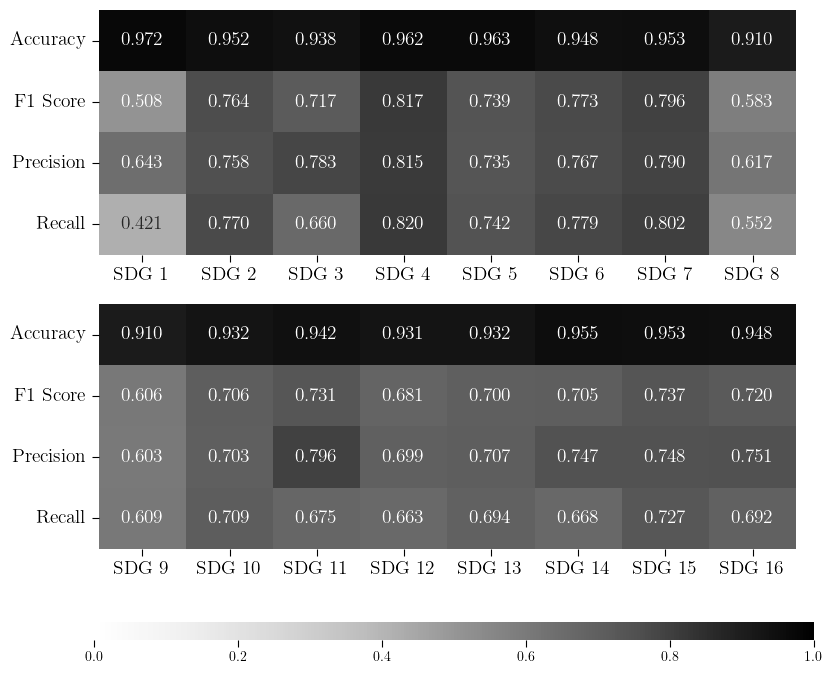

In [155]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
figname = "binary_heatmap.png"

ax[0].tick_params(axis="x", labelsize=14)
ax[1].tick_params(axis="x", labelsize=14)

ax[0].tick_params(axis="y", labelsize=14)
ax[1].tick_params(axis="y", labelsize=14)

cbar_ax = fig.add_axes([.12, -.02, .8, .025])

sns.heatmap(binary_metrics1, annot=values_str1, ax=ax[0], fmt="s", cmap="Greys", 
            vmin=0, vmax=1, cbar_kws={"orientation": "horizontal"}, 
            annot_kws={"fontsize": 14, "fontweight": "black"}, 
            cbar_ax=cbar_ax)

sns.heatmap(binary_metrics2, annot=values_str2, ax=ax[1], fmt="s", cmap="Greys", 
            vmin=0, vmax=1, cbar_kws={"orientation": "horizontal"}, 
            annot_kws={"fontsize": 14, "fontweight": "black"},
            cbar_ax=cbar_ax)

plt.savefig(os.path.join(directory, figname), bbox_inches="tight", dpi=800)
plt.show()